<a href="https://colab.research.google.com/github/EgorSu/house_price/blob/main/house_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [226]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
from catboost import cv, Pool

Выводим информацию о датасете. 

In [2]:
data = pd.read_csv('train.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Некторые столбцы имеюют много пропусков. Создадим список столбцов для удаления и добавим туда названия этих столбцов.

In [35]:
drop_list = list(data.loc[:, data.count() < 0.7 * data.shape[0]].columns)
drop_list.append('Id')

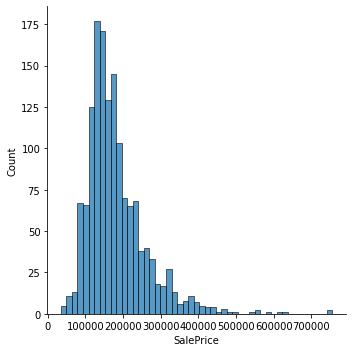

In [36]:
sns.displot(data, x = 'SalePrice')

Целевая переменая имеет смещение к началу координат. Поэтому будем брать логарифм целевой переменной.

In [37]:
categorial_features = list(data.select_dtypes(include = ["object"]).columns)
number_features = list(data.select_dtypes(include = ["number"]).columns)
number_features.remove('SalePrice')
number_features.remove('Id')

Выведем распределение значений и количество уникальных значений для каждого числового признака. Распределение значений представлено в файле house_price_picture.

In [38]:
for i in number_features:
    #sns.displot(data = data, x = i)
    print(data[i].nunique())
    #plt.show()

15
110
1073
10
9
112
61
327
637
144
780
721
753
417
24
861
4
3
4
3
8
4
12
4
97
5
441
274
202
120
20
76
8
21
12
5


Некторые числовые признаки на самом деле являются категориальными и могут иметь только ограниченное кол-во уникальных значений. Переопределим список категориальных и численных признаков. 

In [197]:
n = 50
categorial_features = list(data.loc[:, data.nunique() <= n].columns)
number_features = list(data.loc[:, data.nunique() > n].columns)
number_features.remove('Id')
number_features.remove('SalePrice')

In [198]:
for i in categorial_features:
    #sns.countplot(data = data, x = i)
    print(data[i].value_counts())
    #plt.show()

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
Pave    1454
Grvl       6
Name: Street, dtype: int64
Grvl    50
Pave    41
Name: Alley, dtype: int64
Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64
Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge   

Видно, что для многих признаков кол-во различных значений очень сильно несбалансированно. В house_price_picture показано процентное соотношение различных значений для каждого признака.

In [199]:
'''
for i in categorial_features:
    ser = data[i].value_counts()/data[i].count()
    sns.barplot(x = ser.index, y = ser.values)
    plt.show()
'''


'\nfor i in categorial_features:\n    ser = data[i].value_counts()/data[i].count()\n    sns.barplot(x = ser.index, y = ser.values)\n    plt.show()\n'

Обработаем эти признаки. Если у признака одно значение встречается горазддо чаще чем остальные, то либо удалим его, либо объеденим все остальные в одну категорию( >= 90% - удаляем этот признак,  от 40% до 90% - объеденим в одну категорию). Иначе считаем, что значения могут быть сбалансированы (объеденим категории, которые встречаются сильно редко). Таким образом получили словарб с признаками, которые нужно будет передлать и дополнили drop_list.

In [200]:
remake_dict = {}
for i in categorial_features:
    val_counts = data[i].value_counts()
    index_max_val = val_counts.index[0]
    index_min_val = val_counts.index[val_counts.shape[0] - 1]
    max_prop = val_counts[index_max_val]/data[i].count()
    min_prop = val_counts[index_min_val]/data[i].count()
    lower_level = min(0.1, 0.5/val_counts.shape[0])
    if max_prop >= 0.9:
        drop_list.append(i)
    elif max_prop >= 0.4:
        remake_dict[i] = [val_counts.index[0]]
    elif min_prop < lower_level: 
        values = list(val_counts.index)
        prop_sum = 0
        for j in reversed(values):
            prop_sum += val_counts[j]/data[i].count()
            if prop_sum < lower_level:
                values.remove(j)
                continue
            remake_dict[i] = values
            break
                

Класс для обработки данных, обучения и оценки модели. Но пока только обработка данных.

In [204]:
class Model():

    def __init__(self, remake: dict, drop: list, number: list, categorial: list, target, fill_number = 0, fill_categorial = 'none', model = None, estimator = None):
        self.remake_features = remake
        self.drop_features = drop
        self.number_features = number
        self.categorial_features = categorial
        self.fill_number_features = fill_number
        self.fill_categorial_features = fill_categorial
        self.target_name = target
        self.dict_encoder = {}
        self.active_encoder = 'none'
        self.model = model
        self.features_estimator = estimator
        self.scaler = StandardScaler()
        self.check_features()

    def check_features(self):
        for i in self.drop_features:
            if i in self.number_features:
                self.number_features.remove(i)
            elif i in self.categorial_features:
                self.categorial_features.remove(i)
            if i in self.remake_features.keys():
                del self.remake_features[i]
                     
    def transform_data(self, x):
        x = x.drop(columns = self.drop_features)
        x[self.categorial_features] = x[self.categorial_features].fillna(self.fill_categorial_features)
        x[self.number_features] = x[self.number_features].fillna(self.fill_number_features)
        self.remake_data(x) 
        return x
    
    def transform_target(self, y):
        self.target_name = 'log_SalePrice'
        return pd.Series(data = self.transform_func(y), index = y.index, name = self.target_name)
    
    def fit_transform(self, x, y):
        x = self.transform_data(x)
        y = self.transform_target(y)
        self.fit_target_encoder(x, y, self.categorial_features)
        x = self.encode_data(x, self.categorial_features)
        x[self.number_features] = self.scaler.fit_transform(x[self.number_features])
        return x, y
    
    def transform(self, x, y):
        x = self.transform_data(x)
        y = self.transform_target(y)
        x = self.encode_data(x, self.categorial_features)
        x[self.number_features] = self.scaler.transform(x[self.number_features])
        return x, y
    
    def create_other_categories(self, data: pd.Series, good_categories: list, new_name = 'Other'):
        return data.apply(lambda x: x if x in good_categories else new_name)
    
    def remake_data(self, data: pd.DataFrame):
        for i in self.remake_features:
            if i in self.number_features:
                j = 0
                while j in self.remake_features[i]:
                    j += 1
                data[i] = self.create_other_categories(data[i], self.remake_features[i], j)
            elif i in self.categorial_features:
                data[i] = self.create_other_categories(data[i], self.remake_features[i], 'other')
            else:
                print('{} not in features list'.format(i))
    
    def transform_func(self, x):
        return np.log(x + 1)
    
    def inverse_transform_func(self, x):
        return np.exp(x) - 1
    
    def encode_data(self, x, feature_names):
        for i in feature_names:
            x.loc[:, i] = x[i].map(self.dict_encoder[i])
        return x
    '''        
    def fit(self, x, y):
        if self.model is not None:
            x, y = self.transform(x, y)
            x[self.number_features] = self.scaler.fit_transform(x[self.number_features])
            if self.features_estimator is not None:
                self.features_estimator.fit(x)
                x = self.features_estimator.transform(x)
            self.model.fit(x, y)    
        else:
            print('model not found')
            
    def score(self, x, y, is_draw = False):
        x_t = self.transform(x, y)
        y_pred = self.predict(x)
        if is_draw:
            sns.displot(data = y - y_pred)
            plt.show()
        print("r2 score {}".format(self.model.score(x_t, y)))
        print("log_loss {}".format(msle(inverse_transform_func(y), self.inverse_transform_func(self.model.predict(x_t))))) 
        print('mean error {}'.format((y - y_pred).mean()))
        
    def predict(self, x):
        return self.model.predict(self.transform_data(x))  
'''  
    def fit_target_encoder(self, x, y, feature_names):
        full = pd.concat([x, y], axis = 1)
        for i in feature_names:
            ser = full[[i, self.target_name]].groupby(i).mean()
            self.dict_encoder[i] = ser[self.target_name].to_dict()
        self.active_encoder = 'target_encoder'
        
    def fit_label_encoder(self, data, feature_names):
        for i in feature_names:
            feature_dict = {}
            ch = 0
            for j in data[i].unique():
                feature_dict[j] = ch
                ch += 1
            self.dict_encoder[i] = feature_dict
        self.active_encoder = 'label_encoder'  
      

In [205]:
x_train, x_test, y_train, y_test = train_test_split(data.drop(columns = ['SalePrice']), data['SalePrice'])


In [231]:
ridge = RidgeCV(alphas = [0.01, 0.05, 0.1, 0.5, 1.0])
model = Model(remake_dict, drop_list, number_features, categorial_features, 'SalePrice', model = ridge)
x_train_transform, y_train_transform = model.fit_transform(x_train, y_train)
x_test_transform, y_test_transform = model.transform(x_test, y_test)
ridge.fit(x_train_transform, y_train_transform)
estimate_model(ridge, x_train_transform, y_train_transform, x_test_transform, y_test_transform)

0.8638427790677952
0.8584438551195742


Попробуем сделать рекурсивный отбор признаков с помощью случайного леса. И обучить линейную модель на оставшихся признаках.

best number of features: 41


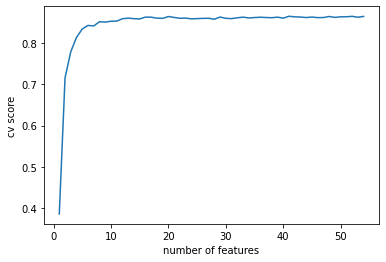

In [212]:
forest = RandomForestRegressor()
mfts = 1
rfecv = RFECV(
    estimator = forest,
    step = 1,
    scoring = "r2",
    min_features_to_select = mfts)
rfecv.fit(x_train_transform, y_train_transform)

print("best number of features: {}".format(rfecv.n_features_))

plt.figure()
plt.xlabel("number of features")
plt.ylabel("cv score")
plt.plot(range(mfts, len(rfecv.grid_scores_) + mfts), rfecv.grid_scores_)
plt.show()

In [229]:
#Эту функцию нужно будет запихать в класс Model
def estimate_model(model, x_1, y_1, x_2, y_2):
    print(model.score(x_1, y_1))
    print(model.score(x_2, y_2))

In [230]:
ridge.fit(rfecv.transform(x_train_transform), y_train_transform)
estimate_model(ridge, rfecv.transform(x_train_transform), y_train_transform, rfecv.transform(x_test_transform), y_test_transform)

0.8592099018710293
0.8569883403483112


In [ ]:
Попробуем обучить catboost на всех признаках.

In [220]:
cat_features = []
parametrs = {"iterations": 1000, "depth": 3, "loss_function": "RMSE", 'cat_features':cat_features}

In [223]:
cat_boost = CatBoostRegressor(**parametrs, verbose = 0)
cat_boost.fit(x_train_transform, y_train_transform)
cat_boost.get_best_score()

{'learn': {'RMSE': 0.07967658881975737}}

счёт на train данных намного больше чем на тестовых, что свидетельствует о переобучении. Нужно будет заняться подбором гиперпараметров.

In [232]:
print(r2_score(y_train_transform, cat_boost.predict(x_train_transform)))
print(r2_score(y_test_transform, cat_boost.predict(x_test_transform)))

0.961095506902532
0.8917861510727468
